In [3]:
import pandas as pd
import numpy as np

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.options.display.max_columns = 99
pd.options.display.max_rows = 999

In [4]:
frac = 0.02

In [5]:

aglo_labels = pd.read_csv('./../data/info/aglo_labels.csv')[['AGLOMERADO', 'NOMAGLO']]

radio_ref = pd.read_csv('./../data/info/radio_ref.csv')
# radio_ref[['PROV','NOMPROV','DPTO', 'NOMDPTO']].drop_duplicates().to_csv('./data/DPTO_PROV.csv', index = False)
dpto_region = pd.read_csv('./../data/info/DPTO_PROV_Region.csv')
radio_ref = radio_ref.merge(dpto_region)
radio_ref = radio_ref[['RADIO_REF_ID', 'NOMDPTO', 'AGLOMERADO', 'Region']].drop_duplicates().merge(aglo_labels)


data = pd.read_csv('./../data/Pobreza/pobreza_'+str(frac)+'_2020.csv')
data['Grupo Etario'] = pd.cut(data.P03, np.arange(-1, 80, 3))#.round(-1) ## Customizar grupo etario

data = data.merge(radio_ref, on = ['RADIO_REF_ID', 'AGLOMERADO'])
data['AGLO_si'] = data.AGLOMERADO != 0

In [6]:
## Coversion a pesos de AGO 20, cuando fue elaborado el informe de INDEC
cpi = pd.read_csv('./../data/info/indice_precios_M.csv', index_col=0)
ix = cpi.loc['2021-01-31'].values[0]/cpi.loc['2020-08-31'].values[0]
ix

1.191192334256602

## Caracteristicas Basicas
### Poblacion total

In [10]:
n_trims = 3

np.round(len(data)/frac/n_trims, -5)

44600000.0

In [9]:
np.round(data.HOGAR_REF_ID.nunique()/frac, -5)

13500000.0

### Poblacion dentro y fuera de AGLOS

In [11]:

(data.groupby('AGLO_si').size()/frac/n_trims).round(-5).astype(int)

AGLO_si
False    16600000
True     28000000
dtype: int64

In [12]:
(data.groupby('AGLO_si')['HOGAR_REF_ID'].nunique()/frac/n_trims).round(-5).astype(int)

AGLO_si
False    1600000
True     2900000
Name: HOGAR_REF_ID, dtype: int64

### Poblacion en Pobreza

In [13]:
## Personas
### Cantidad
pob_cnt = (data.loc[data.AGLO_si].groupby(['Pobreza', 'Q']).size()/frac/n_trims)
pob_cnt.round(-4).astype(int).unstack()

Q,2020-03-31,2020-06-30,2020-09-30
Pobreza,,,
False,5790000,4990000,5490000
True,3550000,4350000,3850000


Q,2019-03-31,2019-06-30,2019-09-30,2019-12-31
Pobreza,,,,
False,4230000,3880000,4200000,3780000
True,2710000,3060000,2740000,3160000


In [21]:
### Porcentaje
n_trims*(100*pob_cnt/pob_cnt.sum()).round(2).unstack()

Q,2020-03-31,2020-06-30,2020-09-30
Pobreza,,,
False,62.01,53.40,58.77
True,37.98,46.62,41.25


Q,2019-03-31,2019-06-30,2019-09-30,2019-12-31
Pobreza,,,,
False,60.8,56.0,60.4,54.4
True,39.2,44.0,39.6,45.6


In [22]:
## Hogares
### Cantidad
pob_cnt = (data.loc[data.AGLO_si].groupby(['Pobreza', 'Q'])['HOGAR_REF_ID'].nunique()/frac/n_trims)  ## ojo porque mal groupby Q suma hogares que puedieron ser pobres en distintos trimestres
pob_cnt.round(-4).astype(int).unstack()

Q,2020-03-31,2020-06-30,2020-09-30
Pobreza,,,
False,2030000,1830000,1960000
True,840000,1040000,910000


In [23]:
### Porcentaje
n_trims*(100*pob_cnt/pob_cnt.sum()).round(1).unstack()

Q,2020-03-31,2020-06-30,2020-09-30
Pobreza,,,
False,70.8,63.6,68.4
True,29.1,36.3,31.5


#### Otras caracteristicas de hogares en pobreza

In [24]:
data_AGLO = data.loc[data.AGLO_si]

# Tamaño promedio del hogar
data_AGLO.loc[data_AGLO.Pobreza].groupby(['HOGAR_REF_ID', 'Q']).size().mean()

# df = pd.read_csv('./../data/training/EPHARG_train_20.csv')
# df.head()#.groupby(['CODUSU', 'TRIMESTRE']).size().mean()

4.224927053438225

In [25]:
# 'Ingreso total familiar promedio' y 'Canasta básica total promedio del hogar'
ITF = data_AGLO.loc[data_AGLO.Pobreza][['HOGAR_REF_ID', 'P47T_hogar', 'CBT']].drop_duplicates().drop('HOGAR_REF_ID', axis = 1).mean()
np.round(ITF/ix, -2)

# ITF_pond = data.loc[data.Pobreza].P47T_hogar.mean()
# np.round(ITF_pond/ix, -2)

P47T_hogar    36900.0
CBT           63900.0
dtype: float64

P47T_hogar    34400.0
CBT           60200.0
dtype: float64

In [26]:
## Brecha
np.round(100*(ITF['CBT']/ITF['P47T_hogar'] - 1), 1)

## Descripcion Brecha
desc = data_AGLO.groupby(['Pobreza', 'Indigencia'])[['P47T_hogar', 'gap_pobreza', 'gap_indigencia']].describe().round(-2).astype(int)
desc.T.loc[desc.columns.get_level_values(1).isin(['mean', 'min', '25%', '50%', '75%', 'max'])].T

P47T_hogar                                          \
                         mean    min    25%     50%     75%       max   
Pobreza Indigencia                                                      
False   False          158200  15000  79900  114200  162500  12642200   
True    False           80900   6600  42700   57200   77200   7333900   
        True            24100      0  11400   21800   33300    469600   

                   gap_pobreza                                          \
                          mean      min    25%    50%    75%       max   
Pobreza Indigencia                                                       
False   False            81300        0  20600  45900  88900  12587000   
True    False           -29700  -818800 -39600 -23900 -11500         0   
        True            -72900 -1066900 -87200 -66400 -49000     -8400   

                   gap_indigencia                                          
                             mean     min    25%    50%     75%       max  
Pobreza Indigencia                                                         
False   False              127000    8500  57200  86200  131300  12619800  
True    False               36400       0  11500  22600   36600   4515900  
        True               -15400 -258100 -22000 -12400   -5500         0

P47T_hogar                                          \
                         mean    min    25%     50%     75%       max   
Pobreza Indigencia                                                      
False   False          177900  13700  74400  106800  152200  18664500   
True    False           58000   6000  38800   53400   71500    571700   
        True            22300      0  11300   20700   31500    136300   

                   gap_pobreza                                         \
                          mean     min    25%    50%    75%       max   
Pobreza Indigencia                                                      
False   False            94700       0  18800  42300  81900  12078800   
True    False           -26000 -256800 -36700 -21900 -10500         0   
        True            -67900 -391500 -83000 -62600 -46200     -7800   

                   gap_indigencia                                          
                             mean     min    25%    50%     75%       max  
Pobreza Indigencia                                                         
False   False              144300    7700  53400  80400  122700  16012500  
True    False               24100       0  10500  20900   34000    337600  
        True               -14300 -143100 -20600 -11900   -5300         0

### Poblacion en Indigencia

In [29]:
## Personas
### Cantidad
pob_cnt = (data.loc[data.AGLO_si].groupby(['Indigencia', 'Q']).size()/frac/n_trims)
pob_cnt.round(-4).astype(int).unstack()

Q,2020-03-31,2020-06-30,2020-09-30
Indigencia,,,
False,8320000,8090000,8280000
True,1020000,1240000,1060000


Q,2019-03-31,2019-06-30,2019-09-30,2019-12-31
Indigencia,,,,
False,6140000,6130000,6120000,6030000
True,800000,810000,820000,910000


In [34]:
### Porcentaje
n_trims*(100*pob_cnt/pob_cnt.sum()).round(1)

Indigencia  Q         
False       2020-03-31    91.5
            2020-06-30    89.7
            2020-09-30    91.5
True        2020-03-31     8.4
            2020-06-30    10.2
            2020-09-30     8.7
Name: HOGAR_REF_ID, dtype: float64

In [31]:
## Hogares
### Cantidad
pob_cnt = data.loc[data.AGLO_si].groupby(['Indigencia', 'Q'])['HOGAR_REF_ID'].nunique()/frac

pob_cnt.round(-4).astype(int).unstack()

Q,2020-03-31,2020-06-30,2020-09-30
Indigencia,,,
False,7890000,7730000,7870000
True,720000,880000,740000


In [35]:
### Porcentaje
n_trims*(100*pob_cnt/pob_cnt.sum()).round(1).unstack()

Q,2020-03-31,2020-06-30,2020-09-30
Indigencia,,,
False,91.5,89.7,91.5
True,8.4,10.2,8.7


#### Otras caracteristicas de hogares en indigencia

In [36]:
data_AGLO = data.loc[data.AGLO_si]

# Tamaño promedio del hogar
data_AGLO.loc[data_AGLO.Indigencia].groupby(['HOGAR_REF_ID', 'Q']).size().mean()

# df = pd.read_csv('./../data/training/EPHARG_train_20.csv')
# df.head()#.groupby(['CODUSU', 'TRIMESTRE']).size().mean()

4.262361726255429

In [37]:
# 'Ingreso total familiar promedio' y 'Canasta básica total promedio del hogar'
ITF = data_AGLO.loc[data_AGLO.Indigencia][['HOGAR_REF_ID', 'P47T_hogar', 'CBA']].drop_duplicates().drop('HOGAR_REF_ID', axis = 1).mean()
np.round(ITF/ix, -2)

# ITF_pond = data.loc[data.Pobreza].P47T_hogar.mean()
# np.round(ITF_pond/ix, -2)

P47T_hogar    16400.0
CBA           26700.0
dtype: float64

## Pobres no indigentes, y no pobres.

In [38]:
data_AGLO = data.loc[data.AGLO_si]

## Personas
### Cantidad
pob_cnt = data_AGLO.groupby(['Pobreza', 'Indigencia', 'Q']).size()/frac
pob_cnt.round(-4).astype(int).unstack()

Q                   2020-03-31  2020-06-30  2020-09-30
Pobreza Indigencia                                    
False   False         17370000    14960000    16460000
True    False          7590000     9330000     8380000
        True           3060000     3730000     3170000

In [39]:
### Porcentaje
n_trims*(100*pob_cnt/pob_cnt.sum()).round(1).unstack()

Q                   2020-03-31  2020-06-30  2020-09-30
Pobreza Indigencia                                    
False   False             62.1        53.4        58.8
True    False             27.0        33.3        30.0
        True              10.8        13.2        11.4

In [40]:
## Hogares
### Cantidad
pob_cnt = data_AGLO.groupby(['Pobreza', 'Indigencia', 'Q'])['HOGAR_REF_ID'].nunique()/frac
pob_cnt.round(-4).astype(int).unstack()

Q                   2020-03-31  2020-06-30  2020-09-30
Pobreza Indigencia                                    
False   False          6100000     5490000     5890000
True    False          1790000     2240000     1980000
        True            720000      880000      740000

In [41]:
### Porcentaje
n_trims*(100*pob_cnt/pob_cnt.sum()).round(1).unstack()

Q                   2020-03-31  2020-06-30  2020-09-30
Pobreza Indigencia                                    
False   False             70.8        63.6        68.4
True    False             20.7        26.1        23.1
        True               8.4        10.2         8.7

## Por grupo etario

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
info = 100*data.groupby(['Grupo Etario'])[['Pobreza', 'Indigencia']].sum().div(data.groupby(['Grupo Etario']).size(), 0)

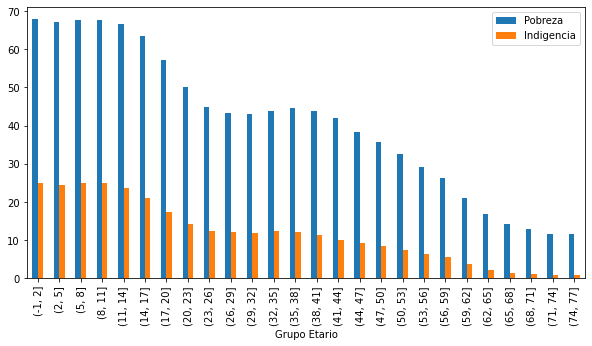

In [44]:
info.plot(kind = 'bar', figsize = (10, 5))
plt.show()

## Geografica

In [45]:
data_AGLO = data.loc[data.AGLO_si].reset_index().rename(columns = {'index': 'PERSONA_ID'})

In [46]:
info_ARG = data_AGLO.groupby(['Pobreza','Indigencia'])[['HOGAR_REF_ID', 'PERSONA_ID']].nunique()
(100*info_ARG/info_ARG.sum()).round(1)

HOGAR_REF_ID  PERSONA_ID
Pobreza Indigencia                          
False   False               58.1        58.1
True    False               30.1        30.1
        True                11.8        11.9

### Por regiones

In [48]:
info_ARG = data_AGLO.groupby(['Region', 'Pobreza','Indigencia'])[['HOGAR_REF_ID', 'PERSONA_ID']].nunique()

# Hogares
cuadro_H = (100*info_ARG.unstack([-2, -1]).div(data_AGLO.groupby('Region')['HOGAR_REF_ID'].nunique(), 0)).round(1)['HOGAR_REF_ID']
(3/4)*cuadro_H

Pobreza             False   True         
Indigencia          False   False   True 
Region                                   
Cuyo               58.500  36.675  12.525
Gran Buenos Aires  63.075  29.625  11.475
Noreste            54.825  39.300  18.675
Noroeste           57.150  36.225  15.525
Pampeana           60.600  32.175  12.750
Patagónica         64.425  32.400   9.600

Pobreza           False True       
Indigencia        False False True 
Region                             
Cuyo               64.4  28.2   7.4
Gran Buenos Aires  73.1  21.0   6.0
Noreste            60.4  28.3  11.2
Noroeste           63.7  26.1  10.2
Pampeana           70.4  22.8   6.8
Patagónica         76.2  19.9   3.9

In [49]:
# Personas
cuadro_P = (100*info_ARG.unstack([-2, -1]).div(data_AGLO.groupby('Region')['PERSONA_ID'].nunique(), 0)).round(1)['PERSONA_ID']
cuadro_P


Pobreza           False True       
Indigencia        False False True 
Region                             
Cuyo               52.5  36.3  11.1
Gran Buenos Aires  61.1  28.0  10.9
Noreste            47.3  34.7  18.0
Noroeste           52.4  33.3  14.2
Pampeana           56.8  30.7  12.5
Patagónica         62.9  28.8   8.3

Pobreza           False True       
Indigencia        False False True 
Region                             
Cuyo               55.8  34.8   9.3
Gran Buenos Aires  63.1  28.5   8.4
Noreste            50.6  34.8  14.6
Noroeste           55.1  31.8  13.1
Pampeana           60.1  30.3   9.6
Patagónica         68.4  26.5   5.1

### Por Aglomerados

In [56]:
info_ARG = data_AGLO.groupby(['Region', 'NOMAGLO', 'Pobreza','Indigencia'])[['HOGAR_REF_ID', 'PERSONA_ID']].nunique()

# Hogares
cuadro_H = (100*info_ARG.unstack([-2, -1]).div(data_AGLO.groupby(['Region', 'NOMAGLO'])['HOGAR_REF_ID'].nunique(), 0)).round(1)['HOGAR_REF_ID']
pob_data = cuadro_H.T.loc[cuadro_H.columns.get_level_values('Pobreza')].T.sum(1)
cuadro_H = pd.concat([cuadro_H, pob_data], axis = 1)
cuadro_H.columns = ['No Pobres', 'Pobres no I.', 'Indigentes', 'Pobres']

cuadro_H.head() ## la suma no da, por alguna razon...

No Pobres  Pobres no I.  Indigentes  Pobres
Region            NOMAGLO                                              
Cuyo              La Rioja       71.1          56.0        21.0    77.0
                  Mendoza        81.8          45.1        14.3    59.4
                  San Juan       72.0          53.8        21.5    75.3
                  San Luis       77.4          51.4        15.1    66.5
Gran Buenos Aires CABA           94.7          20.1         7.5    27.6

No Pobres  Pobres no I.  Indigentes  Pobres
Region            NOMAGLO                                              
Cuyo              La Rioja       56.8          34.3         8.8    43.1
                  Mendoza        68.1          26.2         5.7    31.9
                  San Juan       59.5          29.7        10.8    40.5
                  San Luis       63.3          28.9         7.8    36.7
Gran Buenos Aires CABA           89.2           8.4         2.5    10.9

In [57]:
# Personas
info_ARG = data_AGLO.groupby(['Region', 'NOMAGLO', 'Pobreza','Indigencia'])[['HOGAR_REF_ID', 'PERSONA_ID']].nunique()

# Hogares
cuadro_P = (100*info_ARG.unstack([-2, -1]).div(data_AGLO.groupby(['Region', 'NOMAGLO'])['PERSONA_ID'].nunique(), 0)).round(1)['PERSONA_ID']

pob_data = cuadro_P.T.loc[cuadro_P.columns.get_level_values('Pobreza')].T.sum(1)
cuadro_P = pd.concat([cuadro_P, pob_data], axis = 1)
cuadro_P.columns = ['No Pobres', 'Pobres no I.', 'Indigentes', 'Pobres']

cuadro_P.head()

No Pobres  Pobres no I.  Indigentes  Pobres
Region            NOMAGLO                                              
Cuyo              La Rioja       45.7          40.9        13.4    54.3
                  Mendoza        56.9          33.9         9.2    43.1
                  San Juan       46.2          38.7        15.0    53.7
                  San Luis       50.7          38.8        10.4    49.2
Gran Buenos Aires CABA           81.5          13.8         4.7    18.5

In [58]:
pd.concat([cuadro_H[['Pobres']], cuadro_P[['Pobres']], 
          cuadro_H[['Indigentes']], cuadro_P[['Indigentes']]], axis = 1).round().astype(int)

Pobres  Pobres  Indigentes  Indigentes
Region            NOMAGLO                                                   
Cuyo              La Rioja                77      54          21          13
                  Mendoza                 59      43          14           9
                  San Juan                75      54          22          15
                  San Luis                66      49          15          10
Gran Buenos Aires CABA                    28      18           8           5
                  GBA                     64      44          18          12
Noreste           Corrientes              76      52          24          18
                  Formosa                 76      55          25          19
                  Posadas                 74      51          24          18
                  Resistencia             81      53          26          18
Noroeste          Catamarca               68      47          20          13
                  Jujuy                   69      48          20          14
                  Salta                   69      47          21          15
                  Sgo del Estero          73      51          21          15
                  Tucuman                 68      46          21          14
Pampeana          Bahia Blanca            49      36          13           9
                  Concordia               76      55          23          19
                  Cordoba                 60      42          18          12
                  GBA                     79      55          24          17
                  La Plata                52      37          15          11
                  Mar del Plata           52      38          13          10
                  Parana                  60      43          15          11
                  Rio Cuarto              61      43          16          12
                  Rosario                 57      41          16          12
                  San Nicolas             65      48          17          14
                  Santa Fe                62      45          19          15
                  Santa Rosa              56      40          14          11
                  Viedma-Patagones        49      38          14          10
Patagónica        Cdro Rivadavia          59      39          14           9
                  Neuquen                 58      38          14           9
                  Rawson-Trelew           56      38          14           9
                  Rio Gallegos            54      37          10           7
                  Ushuaia-Rio Grande      47      31           8           5
                  Viedma-Patagones        58      41          15          10

Pobres  Pobres  Indigentes  Indigentes
Region            NOMAGLO                                                   
Cuyo              La Rioja                43      52           9          11
                  Mendoza                 32      41           6           7
                  San Juan                40      46          11          13
                  San Luis                37      48           8          10
Gran Buenos Aires CABA                    11      16           2           3
                  GBA                     33      42           7          10
Noreste           Corrientes              39      48          11          14
                  Formosa                 42      51          11          13
                  Posadas                 37      48          11          15
                  Resistencia             41      51          12          15
Noroeste          Catamarca               33      43           8          11
                  Jujuy                   36      44          10          13
                  Salta                   36      44          10          13
                  Sgo del Estero          39      47          10          13
                  Tucuman                 36      45          11          14
Pampeana          Bahia Blanca            22      31           4           6
                  Concordia               42      54          13          19
                  Cordoba                 30      40           7          10
                  GBA                     42      53          10          13
                  La Plata                22      31           4           6
                  Mar del Plata           25      35           5           6
                  Parana                  30      39           7           9
                  Rio Cuarto              30      39           6           7
                  Rosario                 29      40           7          10
                  San Nicolas             33      43           8          11
                  Santa Fe                30      41           8          12
                  Santa Rosa              24      34           5           7
                  Viedma-Patagones        30      41           5           7
Patagónica        Cdro Rivadavia          24      31           4           6
                  Neuquen                 25      33           4           5
                  Rawson-Trelew           26      34           5           6
                  Rio Gallegos            22      31           3           5
                  Ushuaia-Rio Grande      19      26           2           2
                  Viedma-Patagones        23      35           8          12

In [38]:
# pobres_CABA = data.loc[(data.PROV == 2) & (data.Pobreza)].groupby(['DPTO', 'IDFRAC']).size().sort_values(ascending = False)/frac
# i = ((pobres_CABA/pobres_CABA.sum()).cumsum() < .9).sum()
# pd.DataFrame(pobres_CABA.iloc[:i])#.sort_index()